<a href="https://colab.research.google.com/github/ajitonelsonn/chronic_disease_predictor/blob/main/create_model/Chronic_Disease_Risk_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Chronic Disease Risk Prediction Model

## Overview
This notebook implements a machine learning system to predict chronic disease risk based on patient data. We'll compare three different models:
- Random Forest
- XGBoost with GPU
- LightGBM with GPU

## Table of Contents
1. Setup and Data Loading
2. Data Preprocessing
3. Feature Engineering
4. Model Training
5. Model Evaluation
6. Prediction System


## 1. Setup and Data Loading
First, let's import all necessary libraries and set up our environment.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# ML libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight

# Utility libraries
import joblib
import warnings
import os

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Set display options for better visibility
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 2. Load Data from Google Drive
First, we'll mount Google Drive and load our datasets.

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.1 Extract Dataset

In [4]:
# Unzip dataset
!unzip -o "/content/drive/MyDrive/Lokahi_Datasets/Lokahi_Innovation_in_Healthcare_Hackahton.zip" -d /content/data

# Define base path
BASE_PATH = '/content/data/Lokahi_Innovation_in_Healthcare_Hackahton/'

Archive:  /content/drive/MyDrive/Lokahi_Datasets/Lokahi_Innovation_in_Healthcare_Hackahton.zip
   creating: /content/data/Lokahi_Innovation_in_Healthcare_Hackahton/
  inflating: /content/data/__MACOSX/._Lokahi_Innovation_in_Healthcare_Hackahton  
  inflating: /content/data/Lokahi_Innovation_in_Healthcare_Hackahton/.DS_Store  
  inflating: /content/data/__MACOSX/Lokahi_Innovation_in_Healthcare_Hackahton/._.DS_Store  
   creating: /content/data/Lokahi_Innovation_in_Healthcare_Hackahton/Claims_Enrollment/
   creating: /content/data/Lokahi_Innovation_in_Healthcare_Hackahton/Claims_Member/
   creating: /content/data/Lokahi_Innovation_in_Healthcare_Hackahton/Claims_Provider/
   creating: /content/data/Lokahi_Innovation_in_Healthcare_Hackahton/Claims_Services/
  inflating: /content/data/Lokahi_Innovation_in_Healthcare_Hackahton/Claims_Enrollment/part-00004-tid-6073918516519982526-f7be9fa7-a8c8-49b2-af50-ba12efe30719-371348-1-c000.snappy.parquet  
  inflating: /content/data/__MACOSX/Lokahi_Inn

### 2.2 Create Data Loading Function

In [5]:
def load_parquet_files(directory):
    """Load and combine all parquet files from a directory"""
    print(f"Loading files from {directory}...")
    df_list = []

    parquet_files = [f for f in os.listdir(os.path.join(BASE_PATH, directory))
                    if f.startswith('part-') and f.endswith('.parquet')]
    print(f"Found {len(parquet_files)} parquet files")

    for file in parquet_files:
        file_path = os.path.join(BASE_PATH, directory, file)
        df = pd.read_parquet(file_path)
        df_list.append(df)

    combined_df = pd.concat(df_list, ignore_index=True)
    print(f"Loaded {len(combined_df)} records")
    return combined_df

### 2.3 Load All Datasets

In [6]:
# Load enrollment data
print("Loading enrollment data...")
enrollment_df = load_parquet_files('Claims_Enrollment')
print("\nEnrollment Dataset Shape:", enrollment_df.shape)
print("\nSample of enrollment data:")
display(enrollment_df.head())

Loading enrollment data...
Loading files from Claims_Enrollment...
Found 10 parquet files
Loaded 21226413 records

Enrollment Dataset Shape: (21226413, 17)

Sample of enrollment data:


,PRIMARY_PERSON_KEY,MEMBER_ID,MEMBER_MONTH_START_DATE,YEARMO,MEM_AGE,RELATION,MEM_MSA_NAME,PAYER_LOB,PAYER_TYPE,PROD_TYPE,QTY_MM_MD,QTY_MM_RX,QTY_MM_DN,QTY_MM_VS,MEM_STAT,PRIMARY_CHRONIC_CONDITION_ROLLUP_ID,PRIMARY_CHRONIC_CONDITION_ROLLUP_DESC
0,26875D03B32937E43CE087F9E,26875D03B32937E43CE087F9E,2022-10-01,202210,41,SUBSCRIBER,"DETROIT-DEARBORN-LIVONIA, MI",COMMERCIAL,PPO,RX,0.0,1.0,0.0,0.0,ACTIVE,139.0,139 - HEALTHY FEMALE (41-64)
1,34027AEF8C54348CA1D5E296F,34027AEF8C54348CA1D5E296F,2022-10-01,202210,51,SUBSCRIBER,"SEATTLE-BELLEVUE-KENT, WA",COMMERCIAL,PPO,DENTAL,0.0,0.0,1.0,0.0,ACTIVE,139.0,139 - HEALTHY FEMALE (41-64)
2,7F6D20B04A71E810264C9E2ED,7F6D20B04A71E810264C9E2ED,2023-02-01,202302,26,None,"BELLINGHAM, WA",MEDICAID,ME,RX,0.0,1.0,0.0,0.0,ACTIVE,138.0,138 - HEALTHY FEMALE (16-40)
3,9288604C83A613288A75E678C,9288604C83A613288A75E678C,2024-05-01,202405,21,None,"SAN DIEGO-CHULA VISTA-CARLSBAD, CA",MEDICAID,ME,RX,0.0,1.0,0.0,0.0,ACTIVE,116.0,116 - NEUROLOGIC DISORDERS
4,9F66864769F43A20F39059C05,9F66864769F43A20F39059C05,2023-09-01,202309,8,SUBSCRIBER,"OXNARD-THOUSAND OAKS-VENTURA, CA",MEDICAID,MLI,RX,0.0,1.0,0.0,0.0,None,137.0,137 - HEALTHY FEMALE (6-15)


In [7]:
# Load services data
print("\nLoading services data...")
services_df = load_parquet_files('Claims_Services')
print("\nServices Dataset Shape:", services_df.shape)
print("\nSample of services data:")
display(services_df.head())


Loading services data...
Loading files from Claims_Services...
Found 10 parquet files
Loaded 6582521 records

Services Dataset Shape: (6582521, 148)

Sample of services data:


,PRIMARY_PERSON_KEY,MEMBER_ID,CLAIM_ID_KEY,SERVICE_LINE,SV_STAT,BILL_PROV_KEY,REF_PROV_KEY,ATT_PROV_KEY,YEARMO,FROM_DATE,TO_DATE,PAID_DATE,ADM_DATE,DIS_DATE,AGE_ON_DOS,RELATION,PAYER_LOB,PAYER_TYPE,MEM_STAT,CLAIM_IN_NETWORK,SERVICE_SETTING,FORM_TYPE,UB_BILL_TYPE,POS,MS_DRG,REV_CODE,PROC_CODE,CPT_MOD_1,CPT_MOD_2,CPT_CCS,CPT_CCS_LABEL,ADM_SRC,ADM_TYPE,DIS_STAT,ICD_DIAG_ADMIT,ICD_DIAG_01,ICD_DIAG_02,ICD_DIAG_03,ICD_DIAG_04,ICD_DIAG_05,ICD_DIAG_06,ICD_DIAG_07,ICD_DIAG_08,ICD_DIAG_09,ICD_DIAG_10,ICD_DIAG_11,ICD_DIAG_12,ICD_DIAG_13,ICD_DIAG_14,ICD_DIAG_15,ICD_DIAG_16,ICD_DIAG_17,ICD_DIAG_18,ICD_DIAG_19,ICD_DIAG_20,ICD_DIAG_21,ICD_DIAG_22,ICD_DIAG_23,ICD_DIAG_24,ICD_DIAG_25,ICD_DIAG_26,ICD_DIAG_27,ICD_DIAG_28,ICD_DIAG_29,ICD_DIAG_30,ICD_DIAG_01_POA,ICD_DIAG_02_POA,ICD_DIAG_03_POA,ICD_DIAG_04_POA,ICD_DIAG_05_POA,ICD_DIAG_06_POA,ICD_DIAG_07_POA,ICD_DIAG_08_POA,ICD_DIAG_09_POA,ICD_DIAG_10_POA,ICD_DIAG_11_POA,ICD_DIAG_12_POA,ICD_DIAG_13_POA,ICD_DIAG_14_POA,ICD_DIAG_15_POA,ICD_DIAG_16_POA,ICD_DIAG_17_POA,ICD_DIAG_18_POA,ICD_DIAG_19_POA,ICD_DIAG_20_POA,ICD_DIAG_21_POA,ICD_DIAG_22_POA,ICD_DIAG_23_POA,ICD_DIAG_24_POA,ICD_DIAG_25_POA,ICD_DIAG_26_POA,ICD_DIAG_27_POA,ICD_DIAG_28_POA,ICD_DIAG_29_POA,ICD_DIAG_30_POA,ICD_PROC_CODE_01,ICD_PROC_CODE_02,ICD_PROC_CODE_03,ICD_PROC_CODE_04,ICD_PROC_CODE_05,ICD_PROC_CODE_06,ICD_PROC_CODE_07,ICD_PROC_CODE_08,ICD_PROC_CODE_09,ICD_PROC_CODE_10,ICD_PROC_CODE_11,ICD_PROC_CODE_12,ICD_PROC_CODE_13,ICD_PROC_CODE_14,ICD_PROC_CODE_15,ICD_PROC_CODE_16,ICD_PROC_CODE_17,ICD_PROC_CODE_18,ICD_PROC_CODE_19,ICD_PROC_CODE_20,ICD_PROC_CODE_21,ICD_PROC_CODE_22,ICD_PROC_CODE_23,ICD_PROC_CODE_24,ICD_PROC_CODE_25,ICD_PROC_CODE_26,ICD_PROC_CODE_27,ICD_PROC_CODE_28,ICD_PROC_CODE_29,ICD_PROC_CODE_30,DIAG_CCS_1_LABEL,DIAG_CCS_2_LABEL,DIAG_CCS_3_LABEL,NDC_CODE,RX_DAYS_SUPPLY,RX_REFILLS,RX_FILL_SRC,RX_DRUG_COST,RX_INGR_COST,RX_QTY_DISPENSED,RX_DISP_FEE,RX_FORM,AMT_BILLED,AMT_ALLOWED,AMT_COB,AMT_COPAY,AMT_DEDUCT,AMT_COINS,AMT_PAID,AMT_DISALLOWED,SV_UNITS,DIAGNOSTIC_CONDITION_CATEGORY_ID,DIAGNOSTIC_CONDITION_CATEGORY_DESC
0,7247AE66C26B278400ABB3A89,7247AE66C26B278400ABB3A89,1515528462067652716207,14,P,C5418037669F4CC9E9D546A3E,7FFA05437A62CA8B1AD678D94,C5418037669F4CC9E9D546A3E,202306,2023-06-14,2023-06-14,2023-10-19,None,None,22,SUBSCRIBER,MEDICAID,MLI,ACTIVE,Y,OUTPATIENT,U,137,None,None,0450,96374,59,None,231,OTHER THERAPEUTIC PROCEDURES,1,1,01,None,R1031,M7989,N83202,M5450,R110,R509,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,SYMPTOMS; SIGNS; AND ILL-DEFINED CONDITIONS AN...,SYMPTOMS; SIGNS; AND ILL-DEFINED CONDITIONS,ABDOMINAL PAIN,None,0.0,0.0,None,0.00,0.00,None,0.00,0.0,263.714469,113.226828,0.0,0.000000,0.0,0.0,112.389067,231.363098,1.00,98,QUESTIONABLE
1,C5631494F3396BD59B6084BBA,C5631494F3396BD59B6084BBA,3911986582468293728441,2,P,FB0EC82603A5DBBC886DC4E79,04EAF4B396D5C1F0F5BD49BA7,04EAF4B396D5C1F0F5BD49BA7,202312,2023-12-21,2023-12-21,2023-12-31,None,None,9,UNKNOWN,MEDICAID,MLI,ACTIVE,Y,PROFESSIONAL,H,None,17,None,None,87502,QW,None,206,"MICROSCOPIC EXAMINATION (BACTERIAL SMEAR, CULT...",None,None,None,None,A084,R109,R112,R197,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,U,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,DISEASES OF THE DIGESTIVE SYSTEM,INTESTINAL INFECTION,INTESTINAL INFECTION,None,0.0,0.0,None,0.00,0.00,None,0.

In [8]:
# Load members data
print("\nLoading members data...")
members_df = load_parquet_files('Claims_Member')
print("\nMembers Dataset Shape:", members_df.shape)
print("\nSample of members data:")
display(members_df.head())


Loading members data...
Loading files from Claims_Member...
Found 2 parquet files
Loaded 907463 records

Members Dataset Shape: (907463, 8)

Sample of members data:


,PRIMARY_PERSON_KEY,MEMBER_ID,MEM_GENDER,MEM_RACE,MEM_ETHNICITY,MEM_ZIP3,MEM_MSA_NAME,MEM_STATE
0,9D86A6B5CEE3D0C4244D0F450,9D86A6B5CEE3D0C4244D0F450,M,None,None,968,"URBAN HONOLULU, HI",HI
1,9D86E2E5B40DA246B4751E3D4,9D86E2E5B40DA246B4751E3D4,F,None,None,941,"SAN FRANCISCO-SAN MATEO-REDWOOD CITY, CA",CA
2,9D876E9ED9B92F01DAB86077D,9D876E9ED9B92F01DAB86077D,F,3,2,941,"SAN FRANCISCO-SAN MATEO-REDWOOD CITY, CA",CA
3,9D8771DD012044F3594FAFC39,9D8771DD012044F3594FAFC39,M,None,None,968,"URBAN HONOLULU, HI",HI
4,9D8795DD01CCFFB8334B6734A,9D8795DD01CCFFB8334B6734A,F,4,2,941,"SAN FRANCISCO-SAN MATEO-REDWOOD CITY, CA",CA


## 3. Feature Engineering
### 3.1 Create Initial Feature Matrix

In [9]:
def create_feature_matrix():
    """Combine all datasets into a single feature matrix"""
    # Enrollment features
    enrollment_features = enrollment_df[[
        'PRIMARY_PERSON_KEY', 'MEM_AGE', 'PAYER_LOB',
        'PRIMARY_CHRONIC_CONDITION_ROLLUP_DESC',
        'PRIMARY_CHRONIC_CONDITION_ROLLUP_ID'
    ]].drop_duplicates()

    # Demographic features
    demographic_features = members_df[[
        'PRIMARY_PERSON_KEY', 'MEM_GENDER', 'MEM_RACE', 'MEM_ETHNICITY'
    ]].drop_duplicates()

    # Service history features
    diagnosis_features = services_df[[
        'PRIMARY_PERSON_KEY', 'DIAG_CCS_1_LABEL',
        'SERVICE_SETTING', 'DIAGNOSTIC_CONDITION_CATEGORY_DESC'
    ]].drop_duplicates()

    # Merge all features
    merged_df = enrollment_features.merge(
        demographic_features,
        on='PRIMARY_PERSON_KEY',
        how='left'
    ).merge(
        diagnosis_features,
        on='PRIMARY_PERSON_KEY',
        how='left'
    )

    print("Initial feature matrix shape:", merged_df.shape)
    return merged_df

In [10]:
# Create initial feature matrix
merged_df = create_feature_matrix()
display(merged_df.head())

Initial feature matrix shape: (7520181, 11)


,PRIMARY_PERSON_KEY,MEM_AGE,PAYER_LOB,PRIMARY_CHRONIC_CONDITION_ROLLUP_DESC,PRIMARY_CHRONIC_CONDITION_ROLLUP_ID,MEM_GENDER,MEM_RACE,MEM_ETHNICITY,DIAG_CCS_1_LABEL,SERVICE_SETTING,DIAGNOSTIC_CONDITION_CATEGORY_DESC
0,26875D03B32937E43CE087F9E,41,COMMERCIAL,139 - HEALTHY FEMALE (41-64),139.0,F,4,3,SYMPTOMS; SIGNS; AND ILL-DEFINED CONDITIONS AN...,PROFESSIONAL,QUESTIONABLE
1,26875D03B32937E43CE087F9E,41,COMMERCIAL,139 - HEALTHY FEMALE (41-64),139.0,F,4,3,SYMPTOMS; SIGNS; AND ILL-DEFINED CONDITIONS AN...,OUTPATIENT,QUESTIONABLE
2,34027AEF8C54348CA1D5E296F,51,COMMERCIAL,139 - HEALTHY FEMALE (41-64),139.0,F,None,None,None,OTHER,NOT MAPPED
3,7F6D20B04A71E810264C9E2ED,26,MEDICAID,138 - HEALTHY FEMALE (16-40),138.0,F,4,2,None,RX,NOT MAPPED
4,9288604C83A613288A75E678C,21,MEDICAID,116 - NEUROLOGIC DISORDERS,116.0,F,4,3,DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS,OUTPATIENT,OTHER CHRONIC DISEASES OF THE NERVOUS SYSTEM


### 3.2 Analyze Chronic Conditions Distribution

Analyzing chronic condition distribution...

Top 20 Most Common Chronic Conditions:


,Count,Percentage
PRIMARY_CHRONIC_CONDITION_ROLLUP_DESC,,
113 - HYPERTENSION (INCLUDES STROKE & PERIPHERAL VASCULAR DISEASE),784427,10.43
138 - HEALTHY FEMALE (16-40),593181,7.89
112 - DIABETES,576790,7.67
104 - RENAL FAILURE AND/OR POST KIDNEY TRANSPLANT,494915,6.58
126 - OTHER CHRONIC CONDITIONS,456849,6.07
103 - CANCER,437584,5.82
139 - HEALTHY FEMALE (41-64),378112,5.03
"121 - DEPRESSION, SUBSTANCE ABUSE AND OTHER MENTAL HEALTH DISORDER",367511,4.89
130 - HEALTHY MALE (16-40),344786,4.58


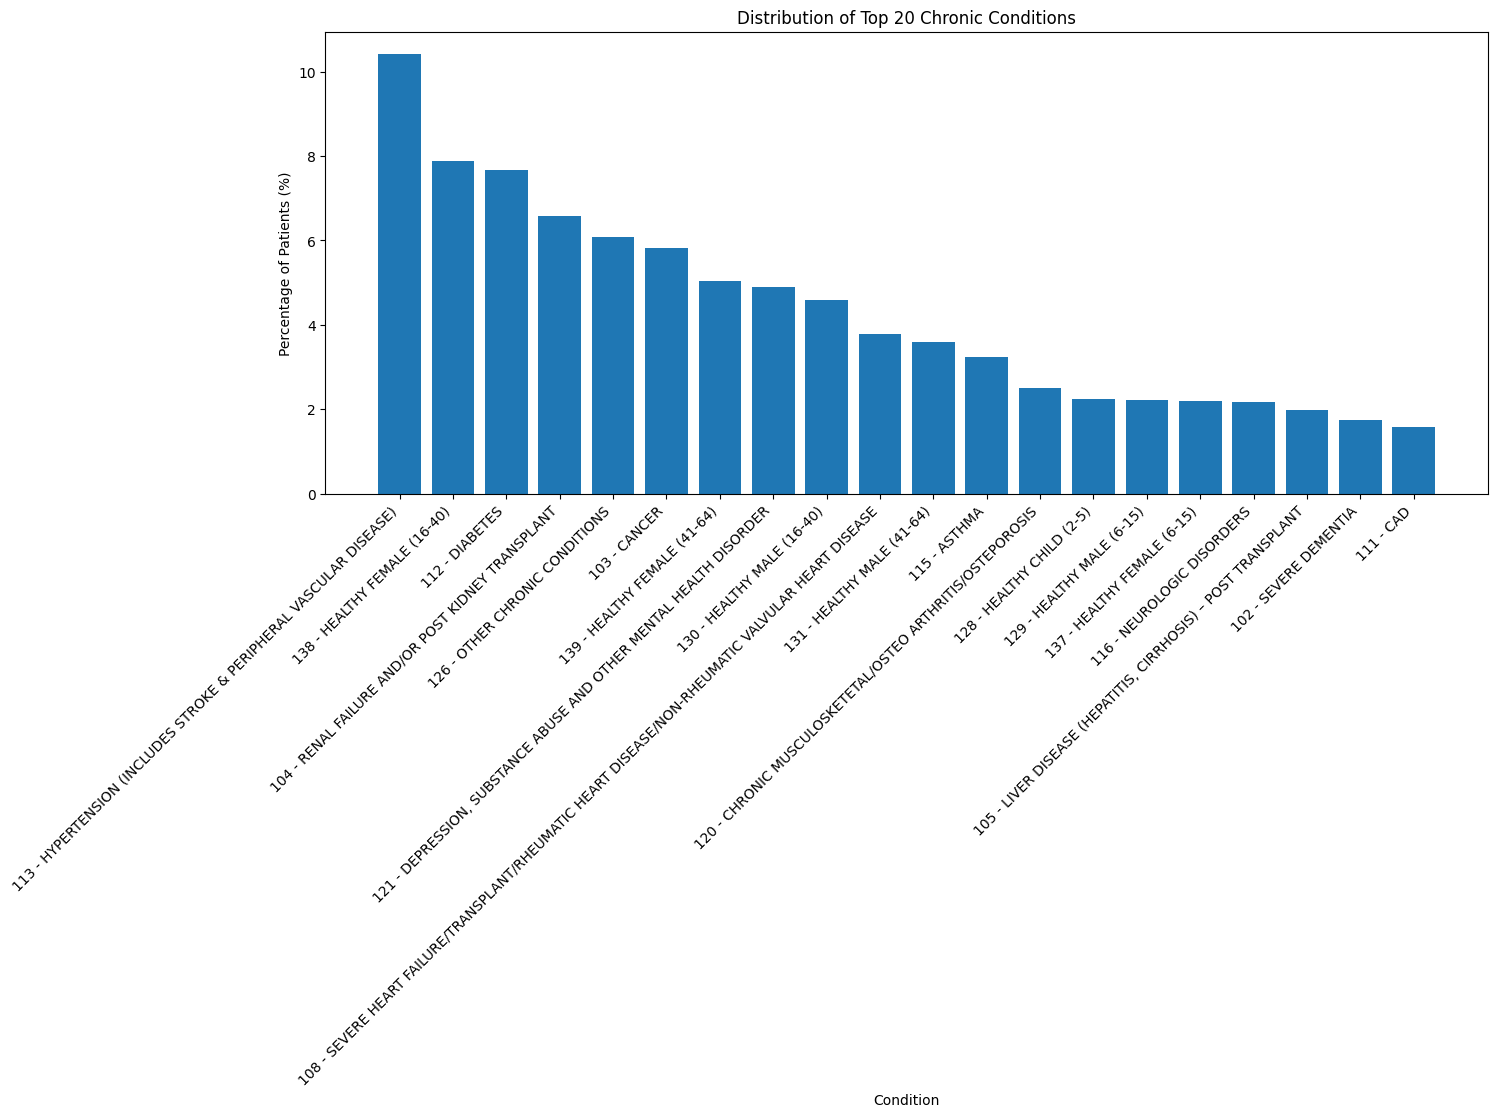

In [11]:
# Analyze distribution of chronic conditions
def analyze_chronic_conditions(df):
    """Analyze and visualize the distribution of chronic conditions"""
    print("Analyzing chronic condition distribution...\n")

    # Get condition distribution
    condition_dist = df['PRIMARY_CHRONIC_CONDITION_ROLLUP_DESC'].value_counts()

    # Calculate percentages
    condition_pct = (condition_dist / len(df) * 100).round(2)

    # Create distribution dataframe
    condition_analysis = pd.DataFrame({
        'Count': condition_dist,
        'Percentage': condition_pct
    })

    print("Top 20 Most Common Chronic Conditions:")
    display(condition_analysis.head(20))

    # Visualize distribution
    plt.figure(figsize=(15, 6))
    plt.bar(range(20), condition_pct.head(20))
    plt.xticks(range(20), condition_dist.head(20).index, rotation=45, ha='right')
    plt.title('Distribution of Top 20 Chronic Conditions')
    plt.xlabel('Condition')
    plt.ylabel('Percentage of Patients (%)')
    plt.tight_layout()
    plt.show()

    return condition_analysis

# Analyze conditions
condition_analysis = analyze_chronic_conditions(merged_df)

### 3.3 Enhanced Feature Engineering with Dynamic Condition Selection
3.2 Advanced Feature Engineering with Complete Chronic Conditions



In [12]:
def engineer_features(df):
    """Create advanced features from the base dataset with complete chronic condition list"""
    # Create age groups
    df['MEM_AGE_NUMERIC'] = pd.to_numeric(df['MEM_AGE'].str.extract('(\d+)', expand=False))
    df['AGE_GROUP'] = pd.cut(df['MEM_AGE_NUMERIC'],
                            bins=[0, 18, 35, 50, 65, 100],
                            labels=['Child', 'Young Adult', 'Adult', 'Middle Age', 'Senior'])

    # Define major conditions with their exact names
    major_conditions = [
        'HYPERTENSION (INCLUDES STROKE & PERIPHERAL VASCULAR DISEASE)',
        'DIABETES',
        'RENAL FAILURE AND/OR POST KIDNEY TRANSPLANT',
        'OTHER CHRONIC CONDITIONS',
        'CANCER',
        'DEPRESSION, SUBSTANCE ABUSE AND OTHER MENTAL HEALTH DISORDER',
        'SEVERE HEART FAILURE/TRANSPLANT/RHEUMATIC HEART DISEASE/NON-RHEUMATIC VALVULAR HEART DISEASE',
        'ASTHMA',
        'CHRONIC MUSCULOSKETETAL/OSTEO ARTHRITIS/OSTEPOROSIS',
        'NEUROLOGIC DISORDERS',
        'LIVER DISEASE (HEPATITIS, CIRRHOSIS) – POST TRANSPLANT',
        'SEVERE DEMENTIA',
        'CAD'
    ]

    # Create simplified column names for conditions
    condition_mappings = {
        'HYPERTENSION (INCLUDES STROKE & PERIPHERAL VASCULAR DISEASE)': 'HYPERTENSION',
        'DIABETES': 'DIABETES',
        'RENAL FAILURE AND/OR POST KIDNEY TRANSPLANT': 'RENAL_FAILURE',
        'OTHER CHRONIC CONDITIONS': 'OTHER_CHRONIC',
        'CANCER': 'CANCER',
        'DEPRESSION, SUBSTANCE ABUSE AND OTHER MENTAL HEALTH DISORDER': 'MENTAL_HEALTH',
        'SEVERE HEART FAILURE/TRANSPLANT/RHEUMATIC HEART DISEASE/NON-RHEUMATIC VALVULAR HEART DISEASE': 'HEART_FAILURE',
        'ASTHMA': 'ASTHMA',
        'CHRONIC MUSCULOSKETETAL/OSTEO ARTHRITIS/OSTEPOROSIS': 'MUSCULOSKELETAL',
        'NEUROLOGIC DISORDERS': 'NEUROLOGIC',
        'LIVER DISEASE (HEPATITIS, CIRRHOSIS) – POST TRANSPLANT': 'LIVER_DISEASE',
        'SEVERE DEMENTIA': 'DEMENTIA',
        'CAD': 'CAD'
    }

    # Create binary flags for each condition
    print("Creating condition flags...")
    for condition, short_name in condition_mappings.items():
        col_name = f'HAS_{short_name}'
        df[col_name] = df['PRIMARY_CHRONIC_CONDITION_ROLLUP_DESC'].str.contains(
            condition, case=False, na=False).astype(int)
        print(f"Created {col_name}")

    # Create condition combinations for high-risk patients
    print("\nCreating condition combinations...")
    high_risk_pairs = [
        ('HYPERTENSION', 'DIABETES'),
        ('HYPERTENSION', 'HEART_FAILURE'),
        ('DIABETES', 'RENAL_FAILURE'),
        ('HEART_FAILURE', 'RENAL_FAILURE'),
        ('MENTAL_HEALTH', 'NEUROLOGIC'),
        ('LIVER_DISEASE', 'RENAL_FAILURE')
    ]

    for cond1, cond2 in high_risk_pairs:
        col_name = f'HAS_{cond1}_AND_{cond2}'
        df[col_name] = df[f'HAS_{cond1}'] * df[f'HAS_{cond2}']
        print(f"Created combination: {col_name}")

    # Create age-condition interactions for key conditions
    print("\nCreating age-condition interactions...")
    key_conditions = ['HYPERTENSION', 'DIABETES', 'HEART_FAILURE', 'CANCER', 'DEMENTIA']
    for condition in key_conditions:
        col_name = f'AGE_X_{condition}'
        df[col_name] = df['MEM_AGE_NUMERIC'] * df[f'HAS_{condition}']
        print(f"Created interaction: {col_name}")

    # Calculate weighted risk score
    print("\nCalculating risk scores...")
    condition_weights = {
        'HEART_FAILURE': 3,
        'RENAL_FAILURE': 3,
        'CANCER': 3,
        'LIVER_DISEASE': 2,
        'HYPERTENSION': 2,
        'DIABETES': 2,
        'MENTAL_HEALTH': 1,
        'ASTHMA': 1,
        'MUSCULOSKELETAL': 1,
        'NEUROLOGIC': 1,
        'DEMENTIA': 2,
        'CAD': 2,
        'OTHER_CHRONIC': 1
    }

    df['WEIGHTED_RISK_SCORE'] = sum(
        df[f'HAS_{condition}'] * weight
        for condition, weight in condition_weights.items()
    )

    # Create risk categories
    df['RISK_CATEGORY'] = pd.cut(
        df['WEIGHTED_RISK_SCORE'],
        bins=[-float('inf'), 2, 4, 6, float('inf')],
        labels=['Low', 'Moderate', 'High', 'Very High']
    )

    print(f"\nCreated {len(df.columns) - len(merged_df.columns)} new features")

    return df

In [13]:
# Apply enhanced feature engineering
merged_df = engineer_features(merged_df)
print("\nFinal feature matrix shape:", merged_df.shape)
print("\nSample of engineered features:")
display(merged_df[['PRIMARY_CHRONIC_CONDITION_ROLLUP_DESC'] +
                 [col for col in merged_df.columns if col.startswith('HAS_')] +
                 ['WEIGHTED_RISK_SCORE', 'RISK_CATEGORY']].head())

Creating condition flags...
Created HAS_HYPERTENSION
Created HAS_DIABETES
Created HAS_RENAL_FAILURE
Created HAS_OTHER_CHRONIC
Created HAS_CANCER
Created HAS_MENTAL_HEALTH
Created HAS_HEART_FAILURE
Created HAS_ASTHMA
Created HAS_MUSCULOSKELETAL
Created HAS_NEUROLOGIC
Created HAS_LIVER_DISEASE
Created HAS_DEMENTIA
Created HAS_CAD

Creating condition combinations...
Created combination: HAS_HYPERTENSION_AND_DIABETES
Created combination: HAS_HYPERTENSION_AND_HEART_FAILURE
Created combination: HAS_DIABETES_AND_RENAL_FAILURE
Created combination: HAS_HEART_FAILURE_AND_RENAL_FAILURE
Created combination: HAS_MENTAL_HEALTH_AND_NEUROLOGIC
Created combination: HAS_LIVER_DISEASE_AND_RENAL_FAILURE

Creating age-condition interactions...
Created interaction: AGE_X_HYPERTENSION
Created interaction: AGE_X_DIABETES
Created interaction: AGE_X_HEART_FAILURE
Created interaction: AGE_X_CANCER
Created interaction: AGE_X_DEMENTIA

Calculating risk scores...

Created 0 new features

Final feature matrix shape:

,PRIMARY_CHRONIC_CONDITION_ROLLUP_DESC,HAS_HYPERTENSION,HAS_DIABETES,HAS_RENAL_FAILURE,HAS_OTHER_CHRONIC,HAS_CANCER,HAS_MENTAL_HEALTH,HAS_HEART_FAILURE,HAS_ASTHMA,HAS_MUSCULOSKELETAL,HAS_NEUROLOGIC,HAS_LIVER_DISEASE,HAS_DEMENTIA,HAS_CAD,HAS_HYPERTENSION_AND_DIABETES,HAS_HYPERTENSION_AND_HEART_FAILURE,HAS_DIABETES_AND_RENAL_FAILURE,HAS_HEART_FAILURE_AND_RENAL_FAILURE,HAS_MENTAL_HEALTH_AND_NEUROLOGIC,HAS_LIVER_DISEASE_AND_RENAL_FAILURE,WEIGHTED_RISK_SCORE,RISK_CATEGORY
0,139 - HEALTHY FEMALE (41-64),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Low
1,139 - HEALTHY FEMALE (41-64),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Low
2,139 - HEALTHY FEMALE (41-64),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Low
3,138 - HEALTHY FEMALE (16-40),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Low
4,116 - NEUROLOGIC DISORDERS,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,Low


### 3.3 Analyze Feature Distributions

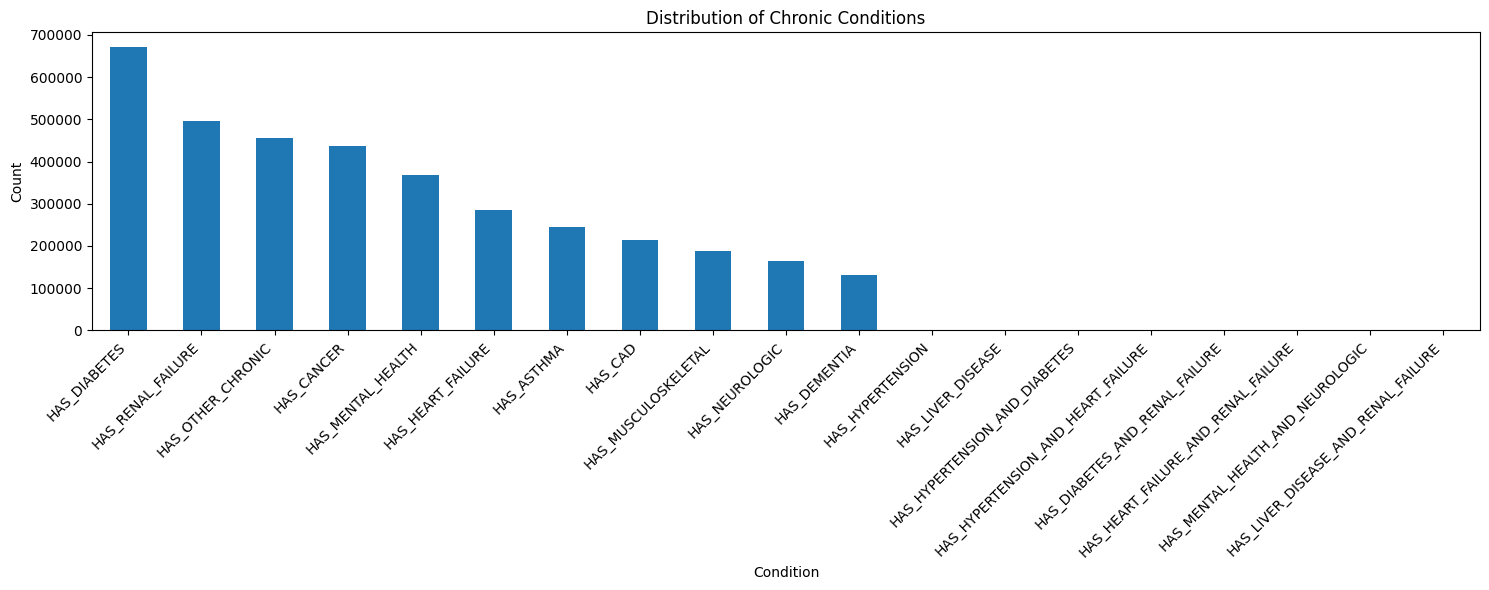

In [14]:
# Analyze distribution of conditions
condition_cols = [col for col in merged_df.columns if col.startswith('HAS_')]
condition_counts = merged_df[condition_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(15, 6))
condition_counts.plot(kind='bar')
plt.title('Distribution of Chronic Conditions')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

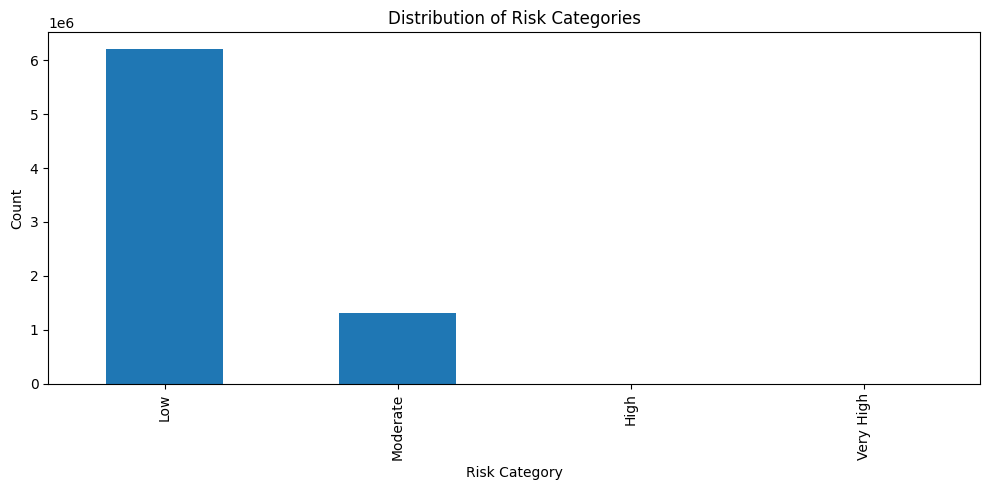

In [15]:
# Show risk category distribution
plt.figure(figsize=(10, 5))
merged_df['RISK_CATEGORY'].value_counts().plot(kind='bar')
plt.title('Distribution of Risk Categories')
plt.xlabel('Risk Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 4. Enhanced Data Preparation
Let's prepare our enhanced feature set for modeling.

In [16]:
def prepare_modeling_data(df):
    """Prepare enhanced data for modeling with proper NaN handling"""
    print("Preparing modeling data...")

    # Create a copy to avoid modifying the original dataframe
    df_prep = df.copy()

    # Remove rows where target variable is NaN
    print("\nHandling missing values...")
    print(f"Original shape: {df_prep.shape}")
    df_prep = df_prep.dropna(subset=['PRIMARY_CHRONIC_CONDITION_ROLLUP_ID'])
    print(f"Shape after removing rows with missing target: {df_prep.shape}")

    # Encode categorical variables
    le = LabelEncoder()
    categorical_columns = [
        'MEM_GENDER', 'MEM_RACE', 'MEM_ETHNICITY', 'PAYER_LOB',
        'SERVICE_SETTING', 'DIAGNOSTIC_CONDITION_CATEGORY_DESC'
    ]

    # Create encoded features
    for col in categorical_columns:
        if col in df_prep.columns:
            # Convert categorical to string and fill NA
            df_prep[col] = df_prep[col].astype(str).fillna('UNKNOWN')
            # Now encode
            df_prep[f'{col}_ENCODED'] = le.fit_transform(df_prep[col])
            print(f"Encoded {col}")

    # Select features for modeling
    feature_columns = (
        # Encoded categorical features
        [col for col in df_prep.columns if col.endswith('_ENCODED')] +
        # Condition flags
        [col for col in df_prep.columns if col.startswith('HAS_')] +
        # Risk scores and age
        ['MEM_AGE_NUMERIC', 'WEIGHTED_RISK_SCORE']
    )

    # Remove any missing columns from feature_columns
    feature_columns = [col for col in feature_columns if col in df_prep.columns]
    print(f"\nSelected {len(feature_columns)} features for modeling")

    # Prepare features and target
    X = df_prep[feature_columns]
    y = df_prep['PRIMARY_CHRONIC_CONDITION_ROLLUP_ID']

    # Fill any remaining NaN values with 0
    X = X.fillna(0)

    # Convert all columns to numeric
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

    # Print missing value information
    print("\nMissing values in features:")
    print(X.isnull().sum().sum(), "total missing values")
    print("\nMissing values in target:")
    print(y.isnull().sum(), "missing values")

    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("\nData split complete:")
    print(f"Training set: {X_train_scaled.shape}")
    print(f"Test set: {X_test_scaled.shape}")

    # Print feature summary
    print("\nFeature summary:")
    feature_summary = pd.DataFrame({
        'Feature': feature_columns,
        'Non_Zero_Count': (X != 0).sum(),
        'Mean': X.mean(),
        'Std': X.std()
    })
    print(feature_summary)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_columns

In [17]:
# Let's also add a function to analyze the target variable distribution
def analyze_target_distribution(y):
    """Analyze and display target variable distribution"""
    print("\nTarget variable distribution:")
    target_dist = pd.Series(y).value_counts()
    print(target_dist)

    plt.figure(figsize=(12, 6))
    target_dist.plot(kind='bar')
    plt.title('Distribution of Target Variable')
    plt.xlabel('Target Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [18]:
# Prepare enhanced data
print("Starting data preparation...")
X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_columns = prepare_modeling_data(merged_df)

Starting data preparation...
Preparing modeling data...

Handling missing values...
Original shape: (7520181, 39)
Shape after removing rows with missing target: (7427650, 39)
Encoded MEM_GENDER
Encoded MEM_RACE
Encoded MEM_ETHNICITY
Encoded PAYER_LOB
Encoded SERVICE_SETTING
Encoded DIAGNOSTIC_CONDITION_CATEGORY_DESC

Selected 27 features for modeling

Missing values in features:
0 total missing values

Missing values in target:
0 missing values

Data split complete:
Training set: (5942120, 27)
Test set: (1485530, 27)

Feature summary:
                                                                               Feature  \
MEM_GENDER_ENCODED                                                  MEM_GENDER_ENCODED   
MEM_RACE_ENCODED                                                      MEM_RACE_ENCODED   
MEM_ETHNICITY_ENCODED                                            MEM_ETHNICITY_ENCODED   
PAYER_LOB_ENCODED                                                    PAYER_LOB_ENCODED   
SERVICE_S


Target variable distribution:
PRIMARY_CHRONIC_CONDITION_ROLLUP_ID
113.0    627542
138.0    474545
112.0    461432
104.0    395932
126.0    365479
103.0    350067
139.0    302490
121.0    294009
130.0    275829
108.0    227728
131.0    216450
115.0    195122
120.0    150976
128.0    135390
129.0    133084
137.0    131876
116.0    131447
105.0    119592
102.0    105358
111.0     94162
123.0     93509
107.0     83891
110.0     76401
122.0     74970
117.0     63634
101.0     62515
114.0     41598
140.0     38031
109.0     33898
132.0     31730
118.0     26819
141.0     21168
106.0     18895
133.0     17708
142.0     14042
145.0     10793
134.0     10475
124.0     10146
143.0      8315
144.0      6409
135.0      5044
136.0      3414
119.0       179
125.0        26
Name: count, dtype: int64


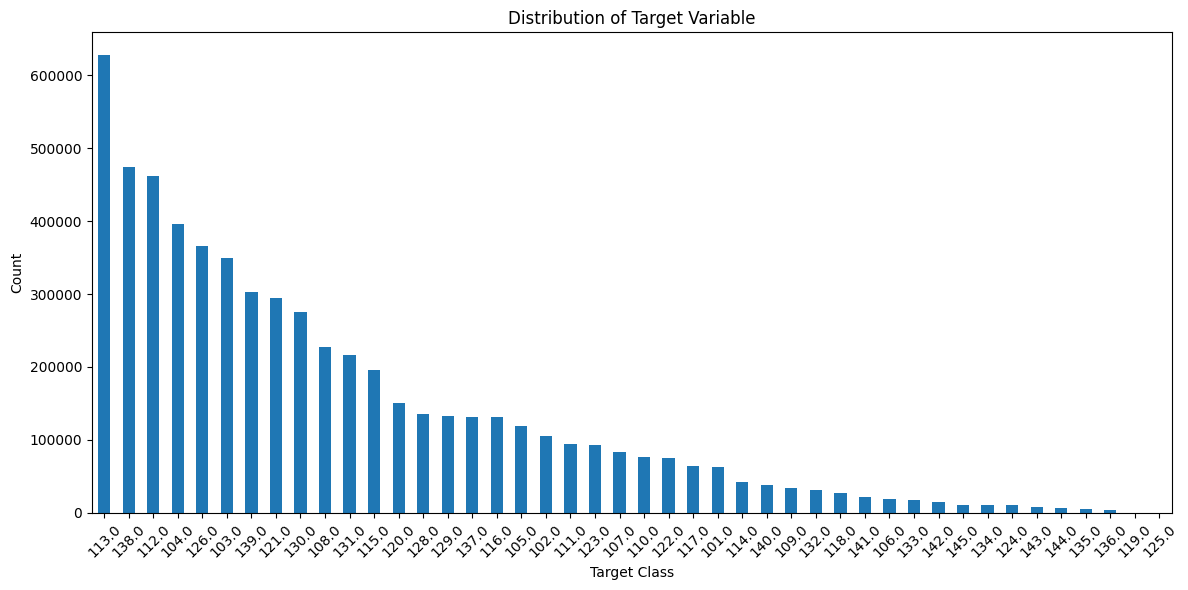

In [19]:
# Analyze target distribution
analyze_target_distribution(y_train)

## 5. Model Training and Comparison

### 5.1 Random Forest Model
Train Random Forest

In [20]:

def train_random_forest(X_train, X_test, y_train, y_test, feature_columns):
    print("Training Random Forest model...")

    rf_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\nRandom Forest Results:")
    print(f"Accuracy: {accuracy:.3f}")
    print("\nClassification Report:")
    print(class_report)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    importances = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    sns.barplot(data=importances.head(15), x='importance', y='feature')
    plt.title('Random Forest - Top 15 Feature Importance')
    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return {
        'model': rf_model,
        'accuracy': accuracy,
        'classification_report': class_report,
        'confusion_matrix': conf_matrix,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

Training Random Forest model...

Random Forest Results:
Accuracy: 0.747

Classification Report:
              precision    recall  f1-score   support

       101.0       0.22      0.20      0.21     15629
       102.0       1.00      1.00      1.00     26339
       103.0       1.00      1.00      1.00     87517
       104.0       1.00      1.00      1.00     98983
       105.0       0.59      0.00      0.00     29898
       106.0       0.04      0.37      0.06      4724
       107.0       0.57      0.01      0.01     20973
       108.0       1.00      1.00      1.00     56932
       109.0       0.80      0.00      0.00      8475
       110.0       1.00      1.00      1.00     19100
       111.0       1.00      1.00      1.00     23540
       112.0       1.00      1.00      1.00    115358
       113.0       1.00      0.00      0.00    156885
       114.0       0.19      0.07      0.10     10399
       115.0       1.00      1.00      1.00     48781
       116.0       1.00      1.00      

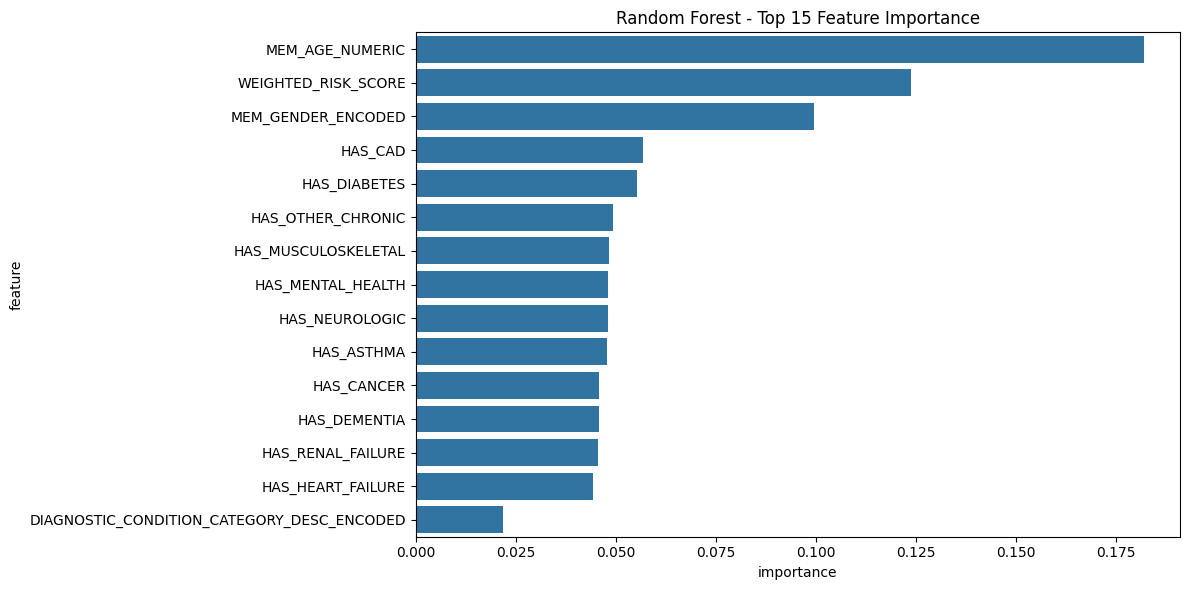

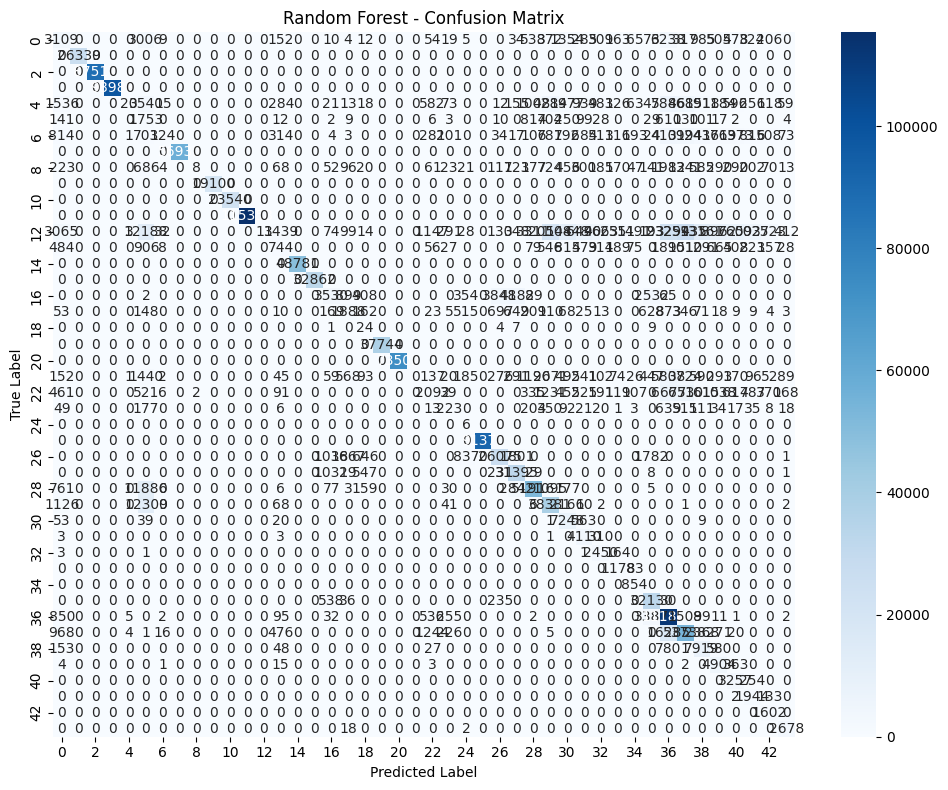

In [22]:
# Train Random Forest model
rf_results = train_random_forest(X_train_scaled, X_test_scaled, y_train, y_test, feature_columns)

### 5.2 XGBoost Model
Train XGBoost

In [30]:

# Train XGBoost
def train_xgboost(X_train, X_test, y_train, y_test, feature_columns):
    print("Training XGBoost model...")

    # Encode target variables
    print("Encoding target variables...")
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Calculate class weights
    classes = np.unique(y_train_encoded)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train_encoded)
    scale_pos_weight = dict(zip(classes, class_weights))

    print(f"Number of classes: {len(classes)}")
    print("Starting model training...")

    xgb_model = XGBClassifier(
        n_estimators=300,
        max_depth=10,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        scale_pos_weight=1,
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        eval_metric=['mlogloss', 'merror'],
        objective='multi:softprob',
        random_state=42
    )

    # Train the model
    eval_set = [(X_test, y_test_encoded)]

    xgb_model.fit(
        X_train, y_train_encoded,
        eval_set=eval_set,
        verbose=True
    )
    print("Model training completed")

    # Make predictions and decode back to original labels
    y_pred_encoded = xgb_model.predict(X_test)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    y_pred_proba = xgb_model.predict_proba(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\nXGBoost Results:")
    print(f"Accuracy: {accuracy:.3f}")
    print("\nClassification Report:")
    print(class_report)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    importances = pd.DataFrame({
        'feature': feature_columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)

    sns.barplot(data=importances.head(15), x='importance', y='feature')
    plt.title('XGBoost - Top 15 Feature Importance')
    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('XGBoost - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Save mapping for future use
    model_artifacts = {
        'model': xgb_model,
        'label_encoder': label_encoder,
        'accuracy': accuracy,
        'classification_report': class_report,
        'confusion_matrix': conf_matrix,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    return model_artifacts

Training XGBoost model...
Encoding target variables...
Number of classes: 44
Starting model training...
[0]	validation_0-mlogloss:3.64562	validation_0-merror:0.22532
[1]	validation_0-mlogloss:3.51990	validation_0-merror:0.18949
[2]	validation_0-mlogloss:3.41580	validation_0-merror:0.18912
[3]	validation_0-mlogloss:3.33661	validation_0-merror:0.18748
[4]	validation_0-mlogloss:3.26002	validation_0-merror:0.18670
[5]	validation_0-mlogloss:3.18710	validation_0-merror:0.18566
[6]	validation_0-mlogloss:3.11038	validation_0-merror:0.18537
[7]	validation_0-mlogloss:3.04607	validation_0-merror:0.18497
[8]	validation_0-mlogloss:2.98894	validation_0-merror:0.18567
[9]	validation_0-mlogloss:2.93547	validation_0-merror:0.18531
[10]	validation_0-mlogloss:2.88423	validation_0-merror:0.18510
[11]	validation_0-mlogloss:2.83127	validation_0-merror:0.18473
[12]	validation_0-mlogloss:2.78595	validation_0-merror:0.18458
[13]	validation_0-mlogloss:2.74415	validation_0-merror:0.18449
[14]	validation_0-mloglo

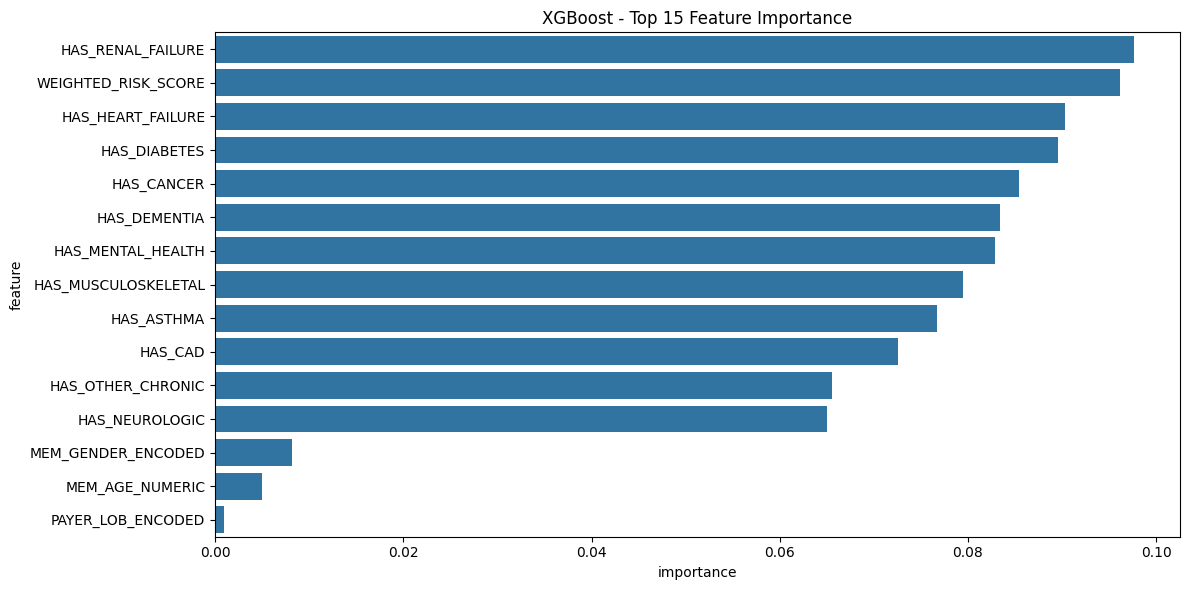

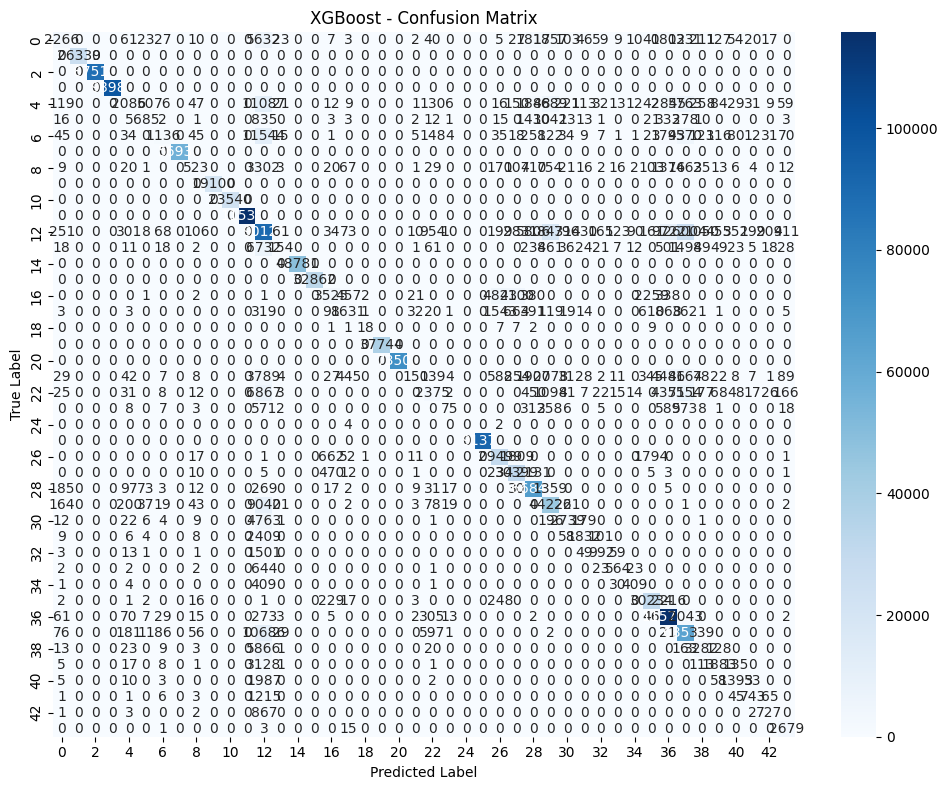

In [31]:
# Train XGBoost model
xgb_results = train_xgboost(X_train_scaled, X_test_scaled, y_train, y_test, feature_columns)

### 5.3 LightGBM Model
Train LightGBM

In [39]:
# Train LightGBM
def train_lightgbm(X_train, X_test, y_train, y_test, feature_columns):
    print("Training LightGBM model with parallel CPU processing...")

    # Encode target variables
    print("Encoding target variables...")
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    print(f"Number of classes: {len(np.unique(y_train_encoded))}")

    # Get number of CPU cores
    num_cores = os.cpu_count()
    print(f"Using {num_cores} CPU cores for parallel processing")

    # Create LightGBM model with optimized CPU configuration
    lgb_model = lgb.LGBMClassifier(
        n_estimators=300,
        max_depth=10,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        class_weight='balanced',
        n_jobs=-1,  # Use all CPU cores
        random_state=42,
        num_threads=num_cores
    )

    # Train with parallel processing
    eval_set = [(X_test, y_test_encoded)]
    print("Starting model training...")

    lgb_model.fit(
        X_train, y_train_encoded,
        eval_set=eval_set,
        eval_metric='multi_logloss'
    )

    print("Model training completed")

    # Make predictions and decode back to original labels
    y_pred_encoded = lgb_model.predict(X_test)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    y_pred_proba = lgb_model.predict_proba(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\nLightGBM Results:")
    print(f"Accuracy: {accuracy:.3f}")
    print("\nClassification Report:")
    print(class_report)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    importances = pd.DataFrame({
        'feature': feature_columns,
        'importance': lgb_model.feature_importances_
    }).sort_values('importance', ascending=False)

    sns.barplot(data=importances.head(15), x='importance', y='feature')
    plt.title('LightGBM - Top 15 Feature Importance')
    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(100, 80))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('LightGBM - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return {
        'model': lgb_model,
        'label_encoder': label_encoder,
        'accuracy': accuracy,
        'classification_report': class_report,
        'confusion_matrix': conf_matrix,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }



Training LightGBM model with parallel CPU processing...
Encoding target variables...
Number of classes: 44
Using 12 CPU cores for parallel processing
Starting model training...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.182342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 5942120, number of used features: 19
[LightGBM] [Info] Start training from score -3.784190
[LightGBM] [Info] Start training from score -3.784190
[LightGBM] [Info] Start training from score -3.784190
[LightGBM] [Info] Start training from score -3.784190
[LightGBM] [Info] Start training from score -3.784190
[LightGBM] [Info] Start training from score -3.784190
[LightGBM] [Info] Start training from score -3.784190
[LightGBM] [Info] Start training from score -3.784190
[LightGBM] [Info] Start training from

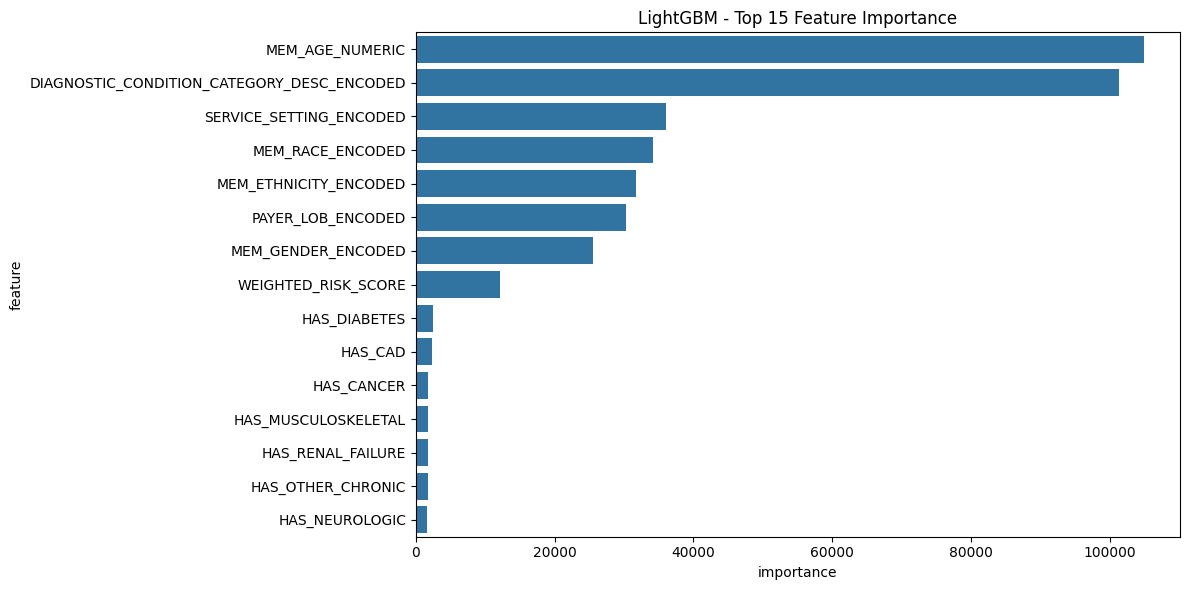

In [40]:
# Train LightGBM model
lgb_results = train_lightgbm(X_train_scaled, X_test_scaled, y_train, y_test, feature_columns)

### 5.4 Compare Models and Save Best Model

In [49]:
def compare_model_performance(results):
    """Compare performance metrics across models with visualizations"""
    comparison = pd.DataFrame()

    for name, result in results.items():
        # Calculate average precision, recall and F1-score directly from the classification report
        report_lines = result['classification_report'].split('\n')[2:-5]  # Skip header and footer
        scores = [line.split() for line in report_lines if line.strip()]

        metrics = {
            'Model': name,
            'Accuracy': result['accuracy'],
            'Avg Precision': np.mean([float(score[-3]) for score in scores]),
            'Avg Recall': np.mean([float(score[-2]) for score in scores]),
            'Avg F1-Score': np.mean([float(score[-1]) for score in scores])
        }
        comparison = pd.concat([comparison, pd.DataFrame([metrics])], ignore_index=True)

    # Create subplot for multiple visualizations
    fig = plt.figure(figsize=(20, 10))

    # 1. Bar plot for overall metrics comparison
    plt.subplot(2, 2, 1)
    comparison.set_index('Model')[['Accuracy', 'Avg Precision', 'Avg Recall', 'Avg F1-Score']].plot(
        kind='bar',
        width=0.8
    )
    plt.title('Model Performance Metrics Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 2. Radar plot for metrics
    plt.subplot(2, 2, 2, projection='polar')
    metrics = ['Accuracy', 'Avg Precision', 'Avg Recall', 'Avg F1-Score']
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # complete the circle

    for idx, model in comparison.iterrows():
        values = model[metrics].values
        values = np.concatenate((values, [values[0]]))  # complete the circle
        plt.plot(angles, values, 'o-', linewidth=2, label=model['Model'])
        plt.fill(angles, values, alpha=0.25)

    plt.xticks(angles[:-1], metrics)
    plt.title('Model Performance Radar Chart')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 3. Heatmap of metrics
    plt.subplot(2, 2, 3)
    sns.heatmap(
        comparison.set_index('Model')[['Accuracy', 'Avg Precision', 'Avg Recall', 'Avg F1-Score']],
        annot=True,
        cmap='YlOrRd',
        fmt='.3f'
    )
    plt.title('Performance Metrics Heatmap')

    # 4. Model ranking plot
    plt.subplot(2, 2, 4)
    rankings = comparison.copy()
    rankings['Overall Score'] = rankings[['Accuracy', 'Avg Precision', 'Avg Recall', 'Avg F1-Score']].mean(axis=1)
    rankings = rankings.sort_values('Overall Score', ascending=True)

    plt.barh(rankings['Model'], rankings['Overall Score'])
    plt.title('Overall Model Performance Ranking')
    plt.xlabel('Average Score Across All Metrics')

    plt.tight_layout()
    plt.show()

    # Print detailed comparison
    print("\nDetailed Performance Comparison:")
    print(comparison.to_string(index=False))

    return comparison

In [50]:
# Combine all results
model_results = {
    'Random Forest': rf_results,
    'XGBoost': xgb_results,
    'LightGBM': lgb_results
}

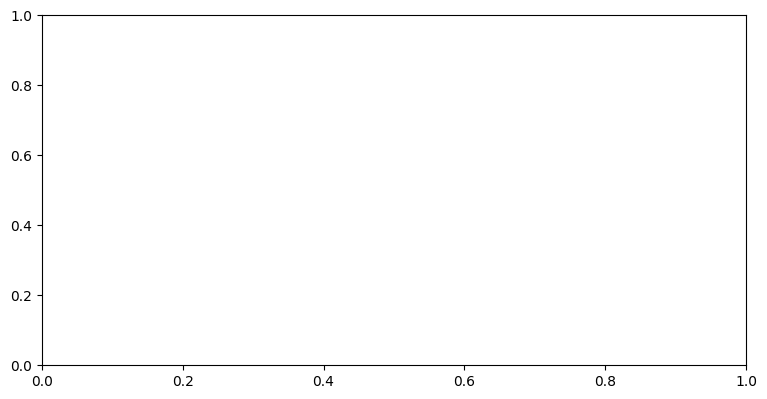

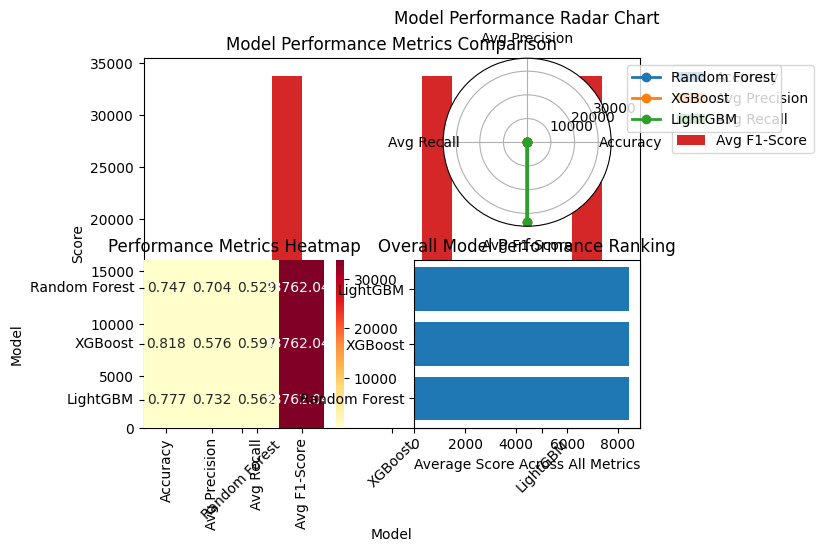


Detailed Performance Comparison:
        Model  Accuracy  Avg Precision  Avg Recall  Avg F1-Score
Random Forest  0.746670       0.704091    0.528636  33762.045455
      XGBoost  0.817565       0.575909    0.596591  33762.045455
     LightGBM  0.777200       0.731818    0.561591  33762.045455


,Model,Accuracy,Avg Precision,Avg Recall,Avg F1-Score
0,Random Forest,0.746670,0.704091,0.528636,33762.045455
1,XGBoost,0.817565,0.575909,0.596591,33762.045455
2,LightGBM,0.777200,0.731818,0.561591,33762.045455


In [51]:
# Compare model performance
performance_comparison = compare_model_performance(model_results)
display(performance_comparison)

In [53]:
# Find best model based on accuracy
best_model_name = performance_comparison.loc[
    performance_comparison['Accuracy'].idxmax(), 'Model'
]
print(f"\nBest performing model based on Accuracy: {best_model_name}")


Best performing model based on Accuracy: XGBoost


In [54]:
# Save best model and components
save_path = '/content/drive/MyDrive/Lokahi_Model/'
os.makedirs(save_path, exist_ok=True)

# Save the best model and its related components
joblib.dump(model_results[best_model_name]['model'],
           f'{save_path}best_chronic_disease_model.joblib')
joblib.dump(scaler, f'{save_path}feature_scaler.joblib')
joblib.dump(model_results[best_model_name]['label_encoder'],
           f'{save_path}label_encoder.joblib')

print(f"\nBest model ({best_model_name}) and components saved to Google Drive")
print(f"Accuracy of best model: {performance_comparison.loc[performance_comparison['Model'] == best_model_name, 'Accuracy'].values[0]:.4f}")


Best model (XGBoost) and components saved to Google Drive
Accuracy of best model: 0.8176


In [55]:
# Save best model and components
save_path = '/content/Lokahi_Model/'
os.makedirs(save_path, exist_ok=True)

# Save the best model and its related components
joblib.dump(model_results[best_model_name]['model'],
           f'{save_path}best_chronic_disease_model.joblib')
joblib.dump(scaler, f'{save_path}feature_scaler.joblib')
joblib.dump(model_results[best_model_name]['label_encoder'],
           f'{save_path}label_encoder.joblib')

print(f"\nBest model ({best_model_name}) and components saved")
print(f"Accuracy of best model: {performance_comparison.loc[performance_comparison['Model'] == best_model_name, 'Accuracy'].values[0]:.4f}")


Best model (XGBoost) and components saved
Accuracy of best model: 0.8176


In [56]:
# Load the saved models and components
loaded_model = joblib.load('/content/Lokahi_Model/best_chronic_disease_model.joblib')
loaded_scaler = joblib.load('/content/Lokahi_Model/feature_scaler.joblib')
loaded_label_encoder = joblib.load('/content/Lokahi_Model/label_encoder.joblib')

In [66]:
# First, let's check the features used in training
print("Features used in training:")
print(feature_columns)

# Create sample patients with matching features
sample_patients = pd.DataFrame([
    {
        # Basic features
        'MEM_AGE_NUMERIC': 45,
        'MEM_GENDER_ENCODED': 1,
        'MEM_RACE_ENCODED': 2,
        'MEM_ETHNICITY_ENCODED': 1,
        'PAYER_LOB_ENCODED': 0,
        'SERVICE_SETTING_ENCODED': 1,
        'DIAGNOSTIC_CONDITION_CATEGORY_DESC_ENCODED': 0,

        # Individual conditions
        'HAS_HYPERTENSION': 0,
        'HAS_DIABETES': 0,
        'HAS_CANCER': 0,
        'HAS_RENAL_FAILURE': 0,
        'HAS_MENTAL_HEALTH': 0,
        'HAS_HEART_FAILURE': 0,
        'HAS_ASTHMA': 0,
        'HAS_MUSCULOSKELETAL': 0,
        'HAS_NEUROLOGIC': 0,
        'HAS_LIVER_DISEASE': 0,
        'HAS_DEMENTIA': 0,
        'HAS_CAD': 0,
        'HAS_OTHER_CHRONIC': 0,

        # Condition interactions
        'HAS_HYPERTENSION_AND_DIABETES': 0,
        'HAS_HYPERTENSION_AND_HEART_FAILURE': 0,
        'HAS_DIABETES_AND_RENAL_FAILURE': 0,
        'HAS_HEART_FAILURE_AND_RENAL_FAILURE': 0,
        'HAS_MENTAL_HEALTH_AND_NEUROLOGIC': 0,
        'HAS_LIVER_DISEASE_AND_RENAL_FAILURE': 0,

        # Age interactions
        'AGE_X_HYPERTENSION': 0,
        'AGE_X_DIABETES': 0,
        'AGE_X_HEART_FAILURE': 0,
        'AGE_X_CANCER': 0,
        'AGE_X_DEMENTIA': 0,

        # Risk score
        'WEIGHTED_RISK_SCORE': 0
    },
    {
        # Elderly patient with multiple conditions
        'MEM_AGE_NUMERIC': 65,
        'MEM_GENDER_ENCODED': 0,
        'MEM_RACE_ENCODED': 1,
        'MEM_ETHNICITY_ENCODED': 0,
        'PAYER_LOB_ENCODED': 1,
        'SERVICE_SETTING_ENCODED': 2,
        'DIAGNOSTIC_CONDITION_CATEGORY_DESC_ENCODED': 1,

        # Individual conditions
        'HAS_HYPERTENSION': 1,
        'HAS_DIABETES': 1,
        'HAS_CANCER': 0,
        'HAS_RENAL_FAILURE': 0,
        'HAS_MENTAL_HEALTH': 0,
        'HAS_HEART_FAILURE': 1,
        'HAS_ASTHMA': 0,
        'HAS_MUSCULOSKELETAL': 1,
        'HAS_NEUROLOGIC': 0,
        'HAS_LIVER_DISEASE': 0,
        'HAS_DEMENTIA': 0,
        'HAS_CAD': 1,
        'HAS_OTHER_CHRONIC': 0,

        # Condition interactions
        'HAS_HYPERTENSION_AND_DIABETES': 1,
        'HAS_HYPERTENSION_AND_HEART_FAILURE': 1,
        'HAS_DIABETES_AND_RENAL_FAILURE': 0,
        'HAS_HEART_FAILURE_AND_RENAL_FAILURE': 0,
        'HAS_MENTAL_HEALTH_AND_NEUROLOGIC': 0,
        'HAS_LIVER_DISEASE_AND_RENAL_FAILURE': 0,

        # Age interactions
        'AGE_X_HYPERTENSION': 65,
        'AGE_X_DIABETES': 65,
        'AGE_X_HEART_FAILURE': 65,
        'AGE_X_CANCER': 0,
        'AGE_X_DEMENTIA': 0,

        # Risk score
        'WEIGHTED_RISK_SCORE': 5
    },
    {
        # Young patient with mental health and asthma
        'MEM_AGE_NUMERIC': 25,
        'MEM_GENDER_ENCODED': 1,
        'MEM_RACE_ENCODED': 0,
        'MEM_ETHNICITY_ENCODED': 1,
        'PAYER_LOB_ENCODED': 0,
        'SERVICE_SETTING_ENCODED': 0,
        'DIAGNOSTIC_CONDITION_CATEGORY_DESC_ENCODED': 2,

        # Individual conditions
        'HAS_HYPERTENSION': 0,
        'HAS_DIABETES': 0,
        'HAS_CANCER': 0,
        'HAS_RENAL_FAILURE': 0,
        'HAS_MENTAL_HEALTH': 1,
        'HAS_HEART_FAILURE': 0,
        'HAS_ASTHMA': 1,
        'HAS_MUSCULOSKELETAL': 0,
        'HAS_NEUROLOGIC': 0,
        'HAS_LIVER_DISEASE': 0,
        'HAS_DEMENTIA': 0,
        'HAS_CAD': 0,
        'HAS_OTHER_CHRONIC': 0,

        # Condition interactions
        'HAS_HYPERTENSION_AND_DIABETES': 0,
        'HAS_HYPERTENSION_AND_HEART_FAILURE': 0,
        'HAS_DIABETES_AND_RENAL_FAILURE': 0,
        'HAS_HEART_FAILURE_AND_RENAL_FAILURE': 0,
        'HAS_MENTAL_HEALTH_AND_NEUROLOGIC': 0,
        'HAS_LIVER_DISEASE_AND_RENAL_FAILURE': 0,

        # Age interactions
        'AGE_X_HYPERTENSION': 0,
        'AGE_X_DIABETES': 0,
        'AGE_X_HEART_FAILURE': 0,
        'AGE_X_CANCER': 0,
        'AGE_X_DEMENTIA': 0,

        # Risk score
        'WEIGHTED_RISK_SCORE': 2
    }
])

Features used in training:
['MEM_GENDER_ENCODED', 'MEM_RACE_ENCODED', 'MEM_ETHNICITY_ENCODED', 'PAYER_LOB_ENCODED', 'SERVICE_SETTING_ENCODED', 'DIAGNOSTIC_CONDITION_CATEGORY_DESC_ENCODED', 'HAS_HYPERTENSION', 'HAS_DIABETES', 'HAS_RENAL_FAILURE', 'HAS_OTHER_CHRONIC', 'HAS_CANCER', 'HAS_MENTAL_HEALTH', 'HAS_HEART_FAILURE', 'HAS_ASTHMA', 'HAS_MUSCULOSKELETAL', 'HAS_NEUROLOGIC', 'HAS_LIVER_DISEASE', 'HAS_DEMENTIA', 'HAS_CAD', 'HAS_HYPERTENSION_AND_DIABETES', 'HAS_HYPERTENSION_AND_HEART_FAILURE', 'HAS_DIABETES_AND_RENAL_FAILURE', 'HAS_HEART_FAILURE_AND_RENAL_FAILURE', 'HAS_MENTAL_HEALTH_AND_NEUROLOGIC', 'HAS_LIVER_DISEASE_AND_RENAL_FAILURE', 'MEM_AGE_NUMERIC', 'WEIGHTED_RISK_SCORE']


In [67]:
def predict_chronic_condition(patient_data):
    """
    Make predictions for patient data
    """
    # Scale the features
    patient_scaled = loaded_scaler.transform(patient_data)

    # Make prediction
    prediction = loaded_model.predict(patient_scaled)
    probabilities = loaded_model.predict_proba(patient_scaled)

    # Get top 3 predictions for each patient
    top_3_indices = np.argsort(-probabilities, axis=1)[:, :3]

    results = []
    for i, (pred, probs, top_3) in enumerate(zip(prediction, probabilities, top_3_indices)):
        result = {
            'Patient': i + 1,
            'Predicted Condition': loaded_label_encoder.inverse_transform([pred])[0],
            'Confidence': f"{probs[pred]*100:.1f}%",
            'Top 3 Predictions': [
                {
                    'Condition': loaded_label_encoder.inverse_transform([idx])[0],
                    'Probability': f"{probs[idx]*100:.1f}%"
                }
                for idx in top_3
            ]
        }
        results.append(result)

    return results

In [74]:
# First, let's print out the feature columns used during training
print("Features used in training:")
print(feature_columns)

# Now create sample patients using only those exact features
def create_sample_patients():
    # Create sample data using only the features that were used in training
    sample_data = pd.DataFrame(columns=feature_columns)

    # Sample patient 1: Middle-aged healthy person
    patient1 = {col: 0 for col in feature_columns}  # Initialize all to 0
    patient1.update({
        'MEM_AGE_NUMERIC': 45,
        'MEM_GENDER_ENCODED': 1,
        'MEM_RACE_ENCODED': 2,
        'MEM_ETHNICITY_ENCODED': 1,
        'PAYER_LOB_ENCODED': 0,
        'SERVICE_SETTING_ENCODED': 1
    })

    # Sample patient 2: Elderly person with multiple conditions
    patient2 = {col: 0 for col in feature_columns}
    patient2.update({
        'MEM_AGE_NUMERIC': 65,
        'MEM_GENDER_ENCODED': 0,
        'MEM_RACE_ENCODED': 1,
        'MEM_ETHNICITY_ENCODED': 0,
        'PAYER_LOB_ENCODED': 1,
        'SERVICE_SETTING_ENCODED': 2,
        'HAS_HYPERTENSION': 1,
        'HAS_DIABETES': 1,
        'HAS_HEART_FAILURE': 1,
        'WEIGHTED_RISK_SCORE': 5
    })

    # Sample patient 3: Young person with mental health and asthma
    patient3 = {col: 0 for col in feature_columns}
    patient3.update({
        'MEM_AGE_NUMERIC': 25,
        'MEM_GENDER_ENCODED': 1,
        'MEM_RACE_ENCODED': 0,
        'MEM_ETHNICITY_ENCODED': 1,
        'PAYER_LOB_ENCODED': 0,
        'SERVICE_SETTING_ENCODED': 0,
        'HAS_MENTAL_HEALTH': 1,
        'HAS_ASTHMA': 1,
        'WEIGHTED_RISK_SCORE': 2
    })

    # Combine all patients
    sample_patients = pd.DataFrame([patient1, patient2, patient3])

    return sample_patients

# Create sample patients with exact matching features
sample_patients = create_sample_patients()

# Make predictions
predictions = predict_chronic_condition(sample_patients)

# Display results
for result in predictions:
    print(f"\nPatient {result['Patient']}:")
    print(f"Predicted Primary Condition: {result['Predicted Condition']}")
    print(f"Prediction Confidence: {result['Confidence']}")
    print("Top 3 Most Likely Conditions:")
    for i, pred in enumerate(result['Top 3 Predictions'], 1):
        print(f"{i}. {pred['Condition']} ({pred['Probability']})")

Features used in training:
['MEM_GENDER_ENCODED', 'MEM_RACE_ENCODED', 'MEM_ETHNICITY_ENCODED', 'PAYER_LOB_ENCODED', 'SERVICE_SETTING_ENCODED', 'DIAGNOSTIC_CONDITION_CATEGORY_DESC_ENCODED', 'HAS_HYPERTENSION', 'HAS_DIABETES', 'HAS_RENAL_FAILURE', 'HAS_OTHER_CHRONIC', 'HAS_CANCER', 'HAS_MENTAL_HEALTH', 'HAS_HEART_FAILURE', 'HAS_ASTHMA', 'HAS_MUSCULOSKELETAL', 'HAS_NEUROLOGIC', 'HAS_LIVER_DISEASE', 'HAS_DEMENTIA', 'HAS_CAD', 'HAS_HYPERTENSION_AND_DIABETES', 'HAS_HYPERTENSION_AND_HEART_FAILURE', 'HAS_DIABETES_AND_RENAL_FAILURE', 'HAS_HEART_FAILURE_AND_RENAL_FAILURE', 'HAS_MENTAL_HEALTH_AND_NEUROLOGIC', 'HAS_LIVER_DISEASE_AND_RENAL_FAILURE', 'MEM_AGE_NUMERIC', 'WEIGHTED_RISK_SCORE']

Patient 1:
Predicted Primary Condition: 131.0
Prediction Confidence: 49.1%
Top 3 Most Likely Conditions:
1. 131.0 (49.1%)
2. 113.0 (10.4%)
3. 105.0 (3.8%)

Patient 2:
Predicted Primary Condition: 108.0
Prediction Confidence: 40.1%
Top 3 Most Likely Conditions:
1. 108.0 (40.1%)
2. 110.0 (37.1%)
3. 112.0 (12.3%)


In [75]:
def print_patient_details(patient):
    """Print detailed patient information"""
    print("\nPatient Details:")
    print(f"Age: {patient['MEM_AGE_NUMERIC']}")
    print(f"Gender: {'Male' if patient['MEM_GENDER_ENCODED'] == 1 else 'Female'}")

    # Print active conditions
    conditions = [col[4:] for col in patient.keys() if col.startswith('HAS_') and patient[col] == 1]
    if conditions:
        print("Active Conditions:", ", ".join(conditions))
    else:
        print("No active conditions")

    print(f"Risk Score: {patient['WEIGHTED_RISK_SCORE']}")

# Make predictions with decoded conditions
predictions = predict_chronic_condition(sample_patients)

# Display results with condition descriptions
for i, (result, patient) in enumerate(zip(predictions, sample_patients.to_dict('records'))):
    print(f"\nPatient {result['Patient']}:")
    print_patient_details(patient)
    print(f"\nPredicted Primary Condition: {condition_mapping.get(result['Predicted Condition'], result['Predicted Condition'])}")
    print(f"Prediction Confidence: {result['Confidence']}")
    print("\nTop 3 Most Likely Conditions:")
    for i, pred in enumerate(result['Top 3 Predictions'], 1):
        condition = condition_mapping.get(float(pred['Condition']), pred['Condition'])
        print(f"{i}. {condition} ({pred['Probability']})")
    print("-" * 80)


Patient 1:

Patient Details:
Age: 45
Gender: Male
No active conditions
Risk Score: 0

Predicted Primary Condition: 131 - HEALTHY MALE (41-64)
Prediction Confidence: 49.1%

Top 3 Most Likely Conditions:
1. 131 - HEALTHY MALE (41-64) (49.1%)
2. 113 - HYPERTENSION (INCLUDES STROKE & PERIPHERAL VASCULAR DISEASE) (10.4%)
3. 105 - LIVER DISEASE (HEPATITIS, CIRRHOSIS) – POST TRANSPLANT (3.8%)
--------------------------------------------------------------------------------

Patient 2:

Patient Details:
Age: 65
Gender: Female
Active Conditions: HYPERTENSION, DIABETES, HEART_FAILURE
Risk Score: 5

Predicted Primary Condition: 108 - SEVERE HEART FAILURE/TRANSPLANT/RHEUMATIC HEART DISEASE/NON-RHEUMATIC VALVULAR HEART DISEASE
Prediction Confidence: 40.1%

Top 3 Most Likely Conditions:
1. 108 - SEVERE HEART FAILURE/TRANSPLANT/RHEUMATIC HEART DISEASE/NON-RHEUMATIC VALVULAR HEART DISEASE (40.1%)
2. 110 - BOTH CAD & DIABETES (37.1%)
3. 112 - DIABETES (12.3%)
-------------------------------------------